# Next-Frame Video Prediction with ConVLSTM
link : https://keras.io/examples/vision/conv_lstm/ <br/>
Description : How to build and train a ConVLSTM model for next-frame video prediction <br/>
Introduction : ConVLSTM 구조는 LSTM 레이어에 ConV Recurrent Cell을 도입하여 시계열 처리와 컴퓨터 비전을 결합한 네트워크라고 할 수 있다. 본 예제에서는 일련의 과거 프레임이 주어졌을 때, 다음에 어떤 비디오 프레임이 들어올지 예측하는 프로세스에 대해 다루고자 한다.

## Setup

In [22]:
import io
import os
import sys
import imageio
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/home/jpark/project/video_pred')
import utils
import warnings
warnings.filterwarnings(action='ignore')


import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import tqdm


from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

tensor_dir = 'tensorboard'
model_dir = 'model'
data_dir = '/home/jpark/data/'

np.random.seed(1123)

In [6]:
# CUDA Connection
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13073206961392251294
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9361883136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13656231122994827948
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2023-02-24 15:10:52.682578: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 15:10:52.713294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 15:10:52.736098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 15:10:52.736228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

## Dataset Construction
본 예제의 경우, "Moving MNIST" 덷이터셋을 활용하였다. 우리는 데이터셋을 다운로드한 후, 이미지를 구성하고 학습 및 검증용 데이터셋으로 가공할 것이다. <br/>
다음 신 예측에 있어서, 우리의 모델은 "f_(n+1)"이라 부르는 다음 신 예측을 위해, "f_n"이라고 불리는 이전 신을 이용할 것이다. 모델이 이러한 예측을 생성할 수 있도록 하려면 입력 데이터가 프레임 y_(n+1)을 예측하는데 사용되는 프레임 x_n인 입력 및 출력을 이동하도록 데이터를 처리해야한다.

In [8]:
# Download and load the dataset.
dataset = np.load(data_dir + 'moving_mnist/mnist_test_seq.npy')
print('dataset.shape :',dataset.shape)

dataset.shape : (20, 10000, 64, 64)


In [9]:
 # Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

print("(samples, frames, w, h, c) :",dataset.shape)

(samples, frames, w, h, c) : (1000, 20, 64, 64, 1)


In [10]:
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)

# train : valid = 9 : 1
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [11]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]    # 0 ~ 18
    y = data[:, 1 : data.shape[1], :, :]        # 1 ~ 19
    return x, y

In [12]:
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

In [13]:
# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## Data Visualization
우리의 데이터셋은 프레임 시퀀스로 이루어져 있으며, 각 시퀀스는 다음 프레임을 예측하는데 사용된다.

Displaying frames for example 700.


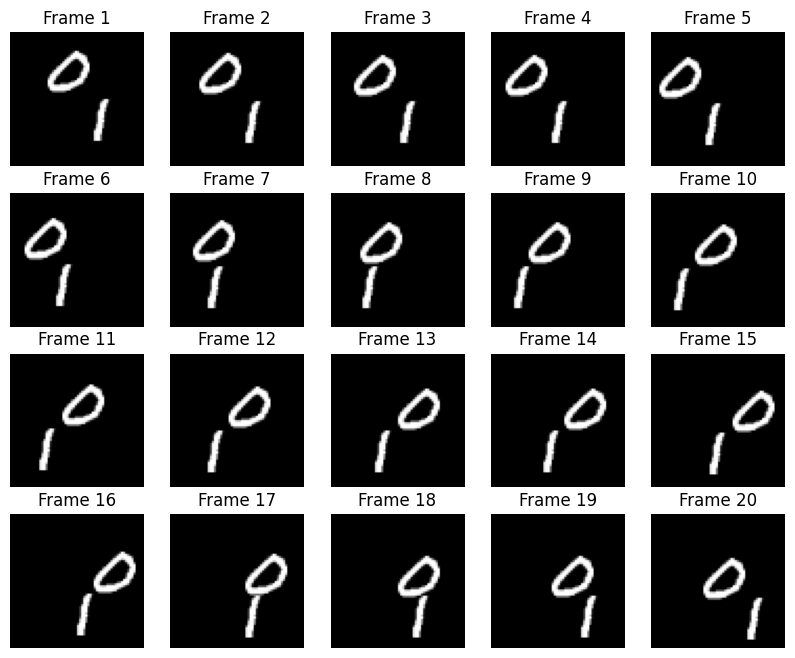

In [14]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction
ConvLSTM 모델을 구축하기 위해, 우리는 "ConvLSTM2D" 레이어를 사용할 것이다. 본 레이어는 (batch_size, num_frames, width, height, channels) 형태의 입력을 받으며, 같은 형식의 예측 무비를 반환한다.

In [15]:
x_train.shape[2:]

(64, 64, 1)

In [16]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)

2023-02-24 15:12:05.980110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 15:12:05.980309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 15:12:05.980396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 15:12:05.980651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 15:12:05.980743: I tensorflow/compiler/xla/stream_executo

In [17]:
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                             

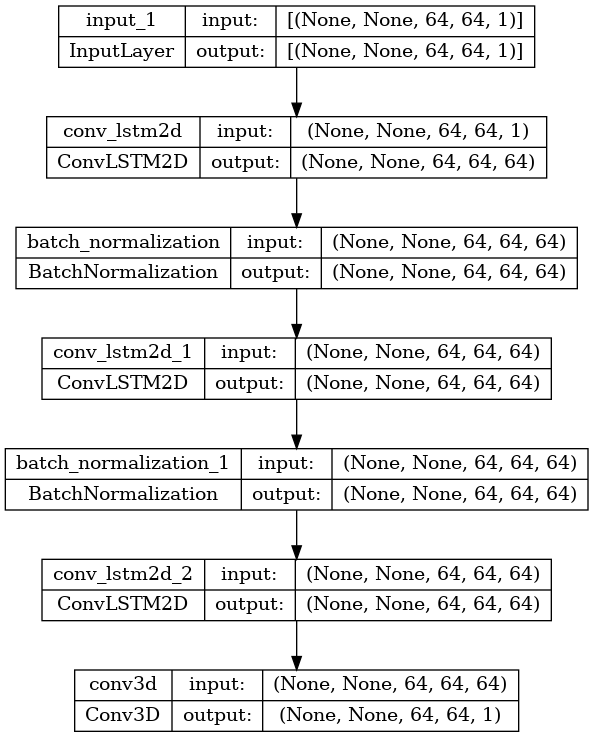

In [18]:
plot_model(model, to_file='figure/model_block_diagram.png',
            show_shapes=True, show_layer_names=True)

## Model Training

In [19]:
# callback function & Tensorboard setting
TB_log_dir = utils.make_tensorboard_dir(tensor_dir)

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    ),
    tfa.callbacks.TQDMProgressBar(),
    keras.callbacks.TensorBoard(log_dir = TB_log_dir),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5)
]

timechecker = utils.TimeHistory("Training")

In [20]:
# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
timechecker.begin()
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks = callbacks_list
)
timechecker.end()
timechecker.print()

2023-02-24 15:12:29.098559: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 280166400 exceeds 10% of free system memory.
2023-02-24 15:12:29.536513: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 280166400 exceeds 10% of free system memory.
2023-02-24 15:12:29.709943: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 280166400 exceeds 10% of free system memory.
2023-02-24 15:12:29.807771: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 280166400 exceeds 10% of free system memory.


Training:   0%|           0/20 ETA: ?s,  ?epochs/s

Epoch 1/20


0/180           ETA: ?s - 

Epoch 1/20


2023-02-24 15:12:32.396866: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 99614720 exceeds 10% of free system memory.
2023-02-24 15:12:32.659011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/input/_1530' -> 'gradient_tape/model/conv_lstm2d_2/while/model/conv_lstm2d_2/while_grad/body/_555/gradient_tape/model/conv_lstm2d_2/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/input/_1649' -> 'gradient_tape/model/conv_lstm2d_1/while/model/conv_lstm2d_1/while_grad/body/_750/gradient_tape/model/conv_lstm2d_1/while/gradients/AddN', 'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_945/input/_1765' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_945

180/180 [==============================] - ETA: 0s - loss: 0.0609

2023-02-24 15:13:42.133734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/model/conv_lstm2d_2/while/body/_97/input/_240' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/mul_2', 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/Relu_1' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/mul_5', 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/convolution_7' -> 'model/conv_lstm2d_2/while/body/_97/model/conv_lstm2d_2/while/add_6', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/convolution_6' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/add_4', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/clip_by_value' -> 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/mul_3', 'model/conv_lstm2d_1/while/body/_49/model/conv_lstm2d_1/while/mul_2' -> 'model/c


Epoch 1: saving model to model/weights_epoch_1
180/180 [==============================] - 75s 381ms/step - loss: 0.0609 - val_loss: 0.1946 - lr: 0.0010
Epoch 2/20


0/180           ETA: ?s - 

Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 0.0275
Epoch 2: saving model to model/weights_epoch_2
180/180 [==============================] - 69s 386ms/step - loss: 0.0275 - val_loss: 0.2358 - lr: 0.0010
Epoch 3/20


0/180           ETA: ?s - 

Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 0.0264
Epoch 3: saving model to model/weights_epoch_3
180/180 [==============================] - 70s 388ms/step - loss: 0.0264 - val_loss: 0.0855 - lr: 0.0010
Epoch 4/20


0/180           ETA: ?s - 

Epoch 4/20
180/180 [==============================] - ETA: 0s - loss: 0.0258
Epoch 4: saving model to model/weights_epoch_4
180/180 [==============================] - 70s 388ms/step - loss: 0.0258 - val_loss: 0.0301 - lr: 0.0010
Epoch 5/20


0/180           ETA: ?s - 

Epoch 5/20
180/180 [==============================] - ETA: 0s - loss: 0.0254
Epoch 5: saving model to model/weights_epoch_5
180/180 [==============================] - 70s 389ms/step - loss: 0.0254 - val_loss: 0.0256 - lr: 0.0010
Epoch 6/20


0/180           ETA: ?s - 

Epoch 6/20
180/180 [==============================] - ETA: 0s - loss: 0.0252
Epoch 6: saving model to model/weights_epoch_6
180/180 [==============================] - 68s 379ms/step - loss: 0.0252 - val_loss: 0.0257 - lr: 0.0010
Epoch 7/20


0/180           ETA: ?s - 

Epoch 7/20
180/180 [==============================] - ETA: 0s - loss: 0.0249
Epoch 7: saving model to model/weights_epoch_7
180/180 [==============================] - 67s 370ms/step - loss: 0.0249 - val_loss: 0.0260 - lr: 0.0010
Epoch 8/20


0/180           ETA: ?s - 

Epoch 8/20
180/180 [==============================] - ETA: 0s - loss: 0.0247
Epoch 8: saving model to model/weights_epoch_8
180/180 [==============================] - 70s 389ms/step - loss: 0.0247 - val_loss: 0.0255 - lr: 0.0010
Epoch 9/20


0/180           ETA: ?s - 

Epoch 9/20
180/180 [==============================] - ETA: 0s - loss: 0.0247
Epoch 9: saving model to model/weights_epoch_9
180/180 [==============================] - 70s 388ms/step - loss: 0.0247 - val_loss: 0.0252 - lr: 0.0010
Epoch 10/20


0/180           ETA: ?s - 

Epoch 10/20
180/180 [==============================] - ETA: 0s - loss: 0.0245
Epoch 10: saving model to model/weights_epoch_10
180/180 [==============================] - 71s 393ms/step - loss: 0.0245 - val_loss: 0.0250 - lr: 0.0010
Epoch 11/20


0/180           ETA: ?s - 

Epoch 11/20
180/180 [==============================] - ETA: 0s - loss: 0.0244
Epoch 11: saving model to model/weights_epoch_11
180/180 [==============================] - 71s 393ms/step - loss: 0.0244 - val_loss: 0.0250 - lr: 0.0010
Epoch 12/20


0/180           ETA: ?s - 

Epoch 12/20
180/180 [==============================] - ETA: 0s - loss: 0.0243
Epoch 12: saving model to model/weights_epoch_12
180/180 [==============================] - 70s 391ms/step - loss: 0.0243 - val_loss: 0.0250 - lr: 0.0010
Epoch 13/20


0/180           ETA: ?s - 

Epoch 13/20
180/180 [==============================] - ETA: 0s - loss: 0.0242
Epoch 13: saving model to model/weights_epoch_13
180/180 [==============================] - 71s 393ms/step - loss: 0.0242 - val_loss: 0.0248 - lr: 0.0010
Epoch 14/20


0/180           ETA: ?s - 

Epoch 14/20
180/180 [==============================] - ETA: 0s - loss: 0.0242
Epoch 14: saving model to model/weights_epoch_14
180/180 [==============================] - 71s 394ms/step - loss: 0.0242 - val_loss: 0.0249 - lr: 0.0010
Epoch 15/20


0/180           ETA: ?s - 

Epoch 15/20
180/180 [==============================] - ETA: 0s - loss: 0.0241
Epoch 15: saving model to model/weights_epoch_15
180/180 [==============================] - 70s 391ms/step - loss: 0.0241 - val_loss: 0.0248 - lr: 0.0010
Epoch 16/20


0/180           ETA: ?s - 

Epoch 16/20
180/180 [==============================] - ETA: 0s - loss: 0.0240
Epoch 16: saving model to model/weights_epoch_16
180/180 [==============================] - 71s 393ms/step - loss: 0.0240 - val_loss: 0.0248 - lr: 0.0010
Epoch 17/20


0/180           ETA: ?s - 

Epoch 17/20
180/180 [==============================] - ETA: 0s - loss: 0.0240
Epoch 17: saving model to model/weights_epoch_17
180/180 [==============================] - 70s 391ms/step - loss: 0.0240 - val_loss: 0.0247 - lr: 0.0010
Epoch 18/20


0/180           ETA: ?s - 

Epoch 18/20
180/180 [==============================] - ETA: 0s - loss: 0.0240
Epoch 18: saving model to model/weights_epoch_18
180/180 [==============================] - 71s 395ms/step - loss: 0.0240 - val_loss: 0.0246 - lr: 0.0010
Epoch 19/20


0/180           ETA: ?s - 

Epoch 19/20
180/180 [==============================] - ETA: 0s - loss: 0.0239
Epoch 19: saving model to model/weights_epoch_19
180/180 [==============================] - 72s 400ms/step - loss: 0.0239 - val_loss: 0.0247 - lr: 0.0010
Epoch 20/20


0/180           ETA: ?s - 

Epoch 20/20
180/180 [==============================] - ETA: 0s - loss: 0.0239
Epoch 20: saving model to model/weights_epoch_20
180/180 [==============================] - 71s 394ms/step - loss: 0.0239 - val_loss: 0.0248 - lr: 0.0010
name : result


In [23]:
timechecker.print()

timechecker.begin()
model.evaluate(x_val,y_val)
timechecker.end()

timechecker.print()

name : result
4/4 [==============================] - 2s 396ms/step - loss: 0.0248
name : result


## Frame Prediction Visualizations
우리의 모델이 구축되고 학습됨에 따라, 우리는 새로운 비디오에 대해 몇 가지 예제 프레임을 예측할 수 있다. <br/>
우리는 Valid set에서 임의의 예제를 뽑은 다음, 그 중에서 처음 10개의 프레임을 선택할 것이다. 거기에서, 우리의 모델은 10개의 새로운 프레임을 예측하도록 할 수 있으며, 이를 실측 프레임 예측과 비교할 수 있다.

In [24]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

print(frames.shape)

(10, 64, 64, 1)


In [25]:
# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

print(predicted_frame.shape)
print(frames.shape)

1/1 [==============================] - 0s 48ms/step
(1, 64, 64, 1)
(20, 64, 64, 1)


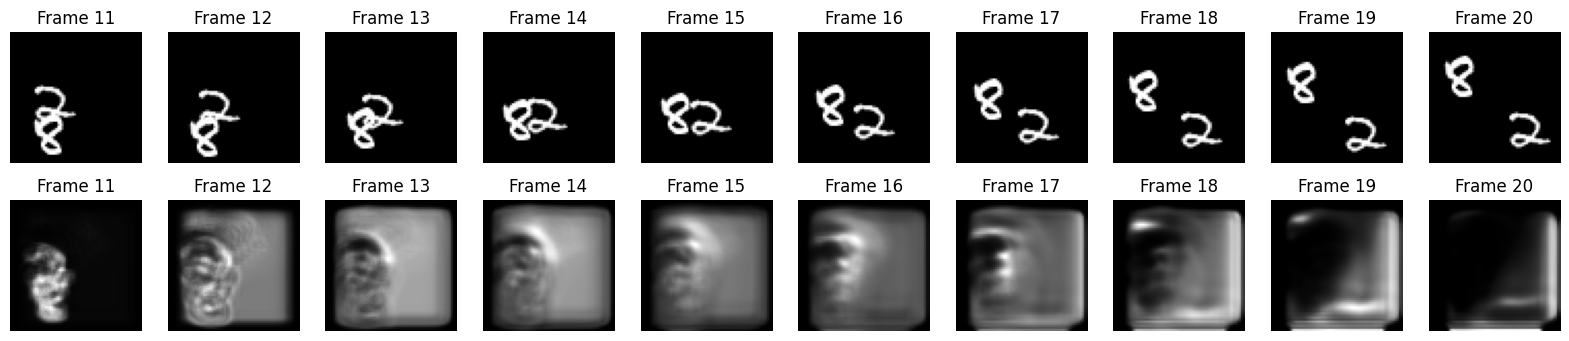

In [26]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx])*255, cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicrted Videos
마지막으로, 우리는 검증 셋엣 몇 가지 샘플을 선정하고, 모델의 예측 비디오를 보기 위해 조금의 GIF를 만들 수 있다. <br/>
우리는 "Huggin Face Hub"에서 주관하는 사전 훈련 모델을 사용할 수 있으며, "Hugging Face Spaces"에서 데모 버전을 돌려볼 수 있다.

In [27]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

1/1 [==============================] - 0s 42ms/step


In [28]:
# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction
